In [1]:
import numpy as np
import torch as pt
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from torch.utils.data import TensorDataset, DataLoader
import sys
import torch
import argparse
from tqdm import tqdm
from torch.autograd import Variable
from pair import PAIR
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# prepare data generating hyper-parameters
seed = 2022
sample_size = [5000, 1000]
batch_size = 512
coffe = 2
n_epoch = 10000
anneal_epoch = 150
algorithm = "erm"
penalty_weight = 1
opt = "Adam"
sampling = "gaussian"
is_uniform = False
if is_uniform:
    x1_l = -3
    x1_r = 1
    y1_l = -3
    y1_r = -2

    x2_l = -1
    x2_r = 3
    y2_l = 2
    y2_r = 3
else:
    mean1 = (-0.9, -2.2)
    cov1 = [[0.9, 0.11], [0.11, 0.1]]
    mean2 = (1, 2)
    cov2 = [[1, -0.3], [-0.3, 0.1]]

# Choosing and saving a random seed for reproducibility
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if seed == -1:
    seed = int(torch.randint(0, 2 ** 32 - 1, (1,)).item())
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


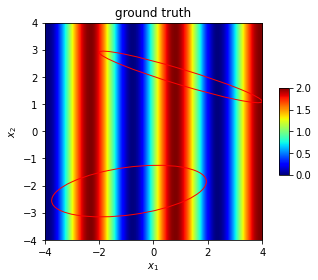

In [2]:
def f_eval(x):
    x = np.asarray(x, dtype=np.float32)
    x = np.delete(x, 1, 1)
    return np.sin(coffe * x) + 1

def f_eval2(x):
    x = np.asarray(x, dtype=np.float32)
    return np.sin(coffe * x[0]) + 1



class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(2, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 1)
        for lin in [self.lin1, self.lin2, self.lin3]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
        self._main = nn.Sequential(self.lin1, nn.ReLU(True), self.lin2, nn.ReLU(True), self.lin3)
        self.optimizer= pt.optim.Adam(self.parameters(), lr=1e-3)

        self.eval()
        r2, r = 1e4, 1e-12
        self.preference = np.array([r]*1+[(1-1*r-r2*r),r2*r])
        self.eps =1e-1
        self.n_tasks = 3
        self.pair_optimizer = PAIR(self.parameters(),self.optimizer,preference=self.preference,eps=self.eps)
        self.descent = 0

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.lin3.reset_parameters()
        self.optimizer= pt.optim.Adam(self.parameters(), lr=1e-3)

    def update_preference(self,preference):
        self.preference=preference
        self.pair_optimizer = PAIR(self.parameters(),self.optimizer,preference=self.preference,eps=self.eps)
        self.descent = 0

    def forward(self, x, to_numpy=False):
        x = pt.as_tensor(x, dtype=pt.float32).to(device)
        out = self._main(x)
        if to_numpy:
            out = out.to('cpu').detach().numpy()
        return out
    
    def train_step(self, x, y):
        self.train()
        x = pt.as_tensor(x, dtype=pt.float32).to(device)
        y = pt.as_tensor(y, dtype=pt.float32).to(device)
        
        self.optimizer.zero_grad()
        y_pred = self.forward(x)
        loss = nn.functional.mse_loss(y_pred, y)
        loss.backward()
        self.optimizer.step()
        self.eval()
        return loss.item()
    
    def train_step_ood(self, x1, y1, x2, y2, apply_ood_obj=False, penalty_weight=1e4):
        self.train()
        x1 = pt.as_tensor(x1, dtype=pt.float32).to(device)
        y1 = pt.as_tensor(y1, dtype=pt.float32).to(device)
        x2 = pt.as_tensor(x2, dtype=pt.float32).to(device)
        y2 = pt.as_tensor(y2, dtype=pt.float32).to(device)

        self.optimizer.zero_grad()
        y1_pred = self.forward(x1)
        loss1 = nn.functional.mse_loss(y1_pred, y1)
        y2_pred = self.forward(x2)
        loss2 = nn.functional.mse_loss(y2_pred, y2)

        import torch.autograd as autograd

        scale = torch.tensor(1.).to(device).requires_grad_()
        losses1 = nn.functional.mse_loss(y1_pred*scale, y1,reduction='none')
        losses2 = nn.functional.mse_loss(y2_pred*scale, y2,reduction='none')
        grad_1 = autograd.grad(losses1.mean(), [scale], create_graph=True)[0]
        grad_2 = autograd.grad(losses2.mean(), [scale], create_graph=True)[0]
        irm_penalty = pt.stack([pt.sum(grad_1**2), pt.sum(grad_2**2)]).mean()
        vrex_penalty = pt.stack([loss1, loss2]).var()

        erm_loss=pt.stack([loss1, loss2]).mean()

        if algorithm.lower() == 'vrex':
            penalty = vrex_penalty
        elif algorithm.lower() == 'pair':
            penalty = vrex_penalty
        else:
            penalty = irm_penalty
        losses = torch.stack([erm_loss,irm_penalty,vrex_penalty]).to(device)
        if apply_ood_obj and algorithm.lower() == 'pair':
            self.pair_optimizer.zero_grad()
            self.pair_optimizer.set_losses(losses=losses)
            loss, moo_losses, mu_rl, alphas = self.pair_optimizer.step()
        else:
            loss = erm_loss+penalty*(penalty_weight if apply_ood_obj else 1)
            if apply_ood_obj and penalty_weight>0:
                loss /= penalty_weight

            loss.backward()
            self.optimizer.step()
            loss = loss.item()
        self.eval()
        return loss, losses
    
    def valid_loss(self, x, y):
        self.eval()
        with pt.no_grad():
            x = pt.as_tensor(x, dtype=pt.float32).to(device)
            y = pt.as_tensor(y, dtype=pt.float32).to(device)

            y_pred = self.forward(x)
            loss = nn.functional.mse_loss(y_pred, y)
        self.train()
        return y_pred.detach(), loss.item()

def prepare_data(gen):
    train_x = []
    train_y = []
    if is_uniform:
        t_x1 = gen.uniform(x1_l, x1_r, [int(sample_size[0]/2), 1])
        t_y1 = gen.uniform(y1_l, y1_r, [int(sample_size[0]/2), 1])
        train_x.append(np.hstack((t_x1, t_y1)))
        t_x2 = gen.uniform(x2_l, x2_r, [int(sample_size[0]/2), 1])
        t_y2 = gen.uniform(y2_l, y2_r, [int(sample_size[0]/2), 1])
        train_x.append(np.hstack((t_x2, t_y2)))
    else:
        t_xy1 = gen.multivariate_normal(mean1, cov1, size=int(sample_size[0]/2))
        train_x.append(t_xy1)
        t_xy2 = gen.multivariate_normal(mean2, cov2, size=int(sample_size[0]/2))
        train_x.append(t_xy2)
    valid_x = gen.uniform(-4, 4, [sample_size[1], 2])
    train_y.append(f_eval(train_x[0]))
    train_y.append(f_eval(train_x[1]))
    valid_y = f_eval(valid_x)
    return train_x, valid_x, train_y, valid_y

def print_truth():
    grid_c = 200
    x = np.linspace(-4, 4, grid_c)
    y = np.linspace(-4, 4, grid_c)
    xy = np.meshgrid(x, y)
    f = f_eval2(xy)
    fig, ax = plt.subplots()
    ax.set_title("ground truth")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    im = ax.imshow(np.array(f), cmap = cm.jet, vmin=0., vmax=2., origin = 'lower', extent=[-4, 4, -4, 4])
    if is_uniform:
        eps = 0.05
        rect1 = patches.Rectangle((x1_l+eps,y1_l+eps),(x1_r-x1_l-2*eps),(y1_r-y1_l-2*eps),linewidth=1,edgecolor='r',facecolor='none')
        rect2 = patches.Rectangle((x2_l+eps,y2_l+eps),(x2_r-x2_l-2*eps),(y2_r-y2_l-2*eps),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
        ax.add_patch(rect2)
    else:
        w, v = np.linalg.eig(cov1)
        theta = np.sign(cov1[0][1]) * np.degrees(np.arccos(v[0,0]))
        ellip1 = patches.Ellipse(mean1, 6*np.sqrt(np.abs(w[0])),6*np.sqrt(np.abs(w[1])), angle=theta,linewidth=1,edgecolor='r',facecolor='none')
        w, v = np.linalg.eig(cov2)
        theta = np.sign(cov2[0][1]) * np.degrees(np.arccos(v[0,0]))
        ellip2 = patches.Ellipse(mean2, 6*np.sqrt(np.abs(w[0])),6*np.sqrt(np.abs(w[1])), angle=theta,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(ellip1)
        ax.add_patch(ellip2)
    # plt.tight_layout()
    fig.colorbar(im, shrink=0.4, aspect=9)
    plt.show()
    # plt.savefig(f'extrapolate_truth_s{sampling}.png')

def print_samples(train_x):
    fig, ax = plt.subplots()
    ax.set_title("training samples")
    plt.plot(np.vstack(train_x)[:, 0], np.vstack(train_x)[:, 1], '.', alpha=0.5)
    if is_uniform:
        eps = 0.05
        rect1 = patches.Rectangle((x1_l+eps,y1_l+eps),(x1_r-x1_l-2*eps),(y1_r-y1_l-2*eps),linewidth=1,edgecolor='r',facecolor='none')
        rect2 = patches.Rectangle((x2_l+eps,y2_l+eps),(x2_r-x2_l-2*eps),(y2_r-y2_l-2*eps),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
        ax.add_patch(rect2)
    else:
        w, v = np.linalg.eig(cov1)
        theta = np.sign(cov1[0][1]) * np.degrees(np.arccos(v[0,0]))
        ellip1 = patches.Ellipse(mean1, 6*np.sqrt(np.abs(w[0])),6*np.sqrt(np.abs(w[1])), angle=theta,linewidth=1,edgecolor='r',facecolor='none')
        w, v = np.linalg.eig(cov2)
        theta = np.sign(cov2[0][1]) * np.degrees(np.arccos(v[0,0]))
        ellip2 = patches.Ellipse(mean2, 6*np.sqrt(np.abs(w[0])),6*np.sqrt(np.abs(w[1])), angle=theta,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(ellip1)
        ax.add_patch(ellip2)
    plt.show()

@torch.no_grad()
def print_predict(model, valid_loss, exp_name=None):
    model.eval()
    grid_c = 200
    x = np.linspace(-4, 4, grid_c)
    y = np.linspace(-4, 4, grid_c)
    f = []
    for _y in y:
        f_r = []
        for _x in x:
            f_r.append(model.forward(x=[_x,_y], to_numpy=True))
        f.append(f_r)
    fig, ax = plt.subplots()
    if exp_name != None:
      ax.set_title(f"{exp_name} {valid_loss}")
    else:
      ax.set_title(f"valid_loss {valid_loss}")

    im = ax.imshow(np.array(f).squeeze(-1), cmap = cm.jet, vmin=0., vmax=2., origin = 'lower', extent=[-4, 4, -4, 4])
    if is_uniform:
        eps = 0.05
        rect1 = patches.Rectangle((x1_l+eps,y1_l+eps),(x1_r-x1_l-2*eps),(y1_r-y1_l-2*eps),linewidth=1,edgecolor='r',facecolor='none')
        rect2 = patches.Rectangle((x2_l+eps,y2_l+eps),(x2_r-x2_l-2*eps),(y2_r-y2_l-2*eps),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
        ax.add_patch(rect2)
    else:
        w, v = np.linalg.eig(cov1)
        theta = np.sign(cov1[0][1]) * np.degrees(np.arccos(v[0,0]))
        ellip1 = patches.Ellipse(mean1, 6*np.sqrt(np.abs(w[0])),6*np.sqrt(np.abs(w[1])), angle=theta,linewidth=1,edgecolor='r',facecolor='none')
        w, v = np.linalg.eig(cov2)
        theta = np.sign(cov2[0][1]) * np.degrees(np.arccos(v[0,0]))
        ellip2 = patches.Ellipse(mean2, 6*np.sqrt(np.abs(w[0])),6*np.sqrt(np.abs(w[1])), angle=theta,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(ellip1)
        ax.add_patch(ellip2)
    # plt.tight_layout()
    fig.colorbar(im, shrink=0.4, aspect=9)
    plt.show()
    # plt.savefig(f'extrapolate_{algorithm}_s{sampling}_{opt}_p{penalty_weight}.png')
    model.train()

@torch.no_grad()
def print_predict3D(model, valid_loss, exp_name=None):
    model.eval()
    grid_c = 200
    x = np.linspace(-4, 4, grid_c)
    y = np.linspace(-4, 4, grid_c)
    f = []
    for _y in y:
        f_r = []
        for _x in x:
            f_r.append(model.forward(x=[_x,_y], to_numpy=True)[0])
        f.append(f_r)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    if exp_name != None:
      ax.set_title(f"{exp_name} {valid_loss}")
    else:
      ax.set_title(f"valid_loss {valid_loss}")
    X_grid, Y_grid = np.meshgrid(x, y)
    f_grid = np.array(f)
    print(f_grid.shape)
    surf = ax.plot_surface(X_grid, Y_grid, np.array(f), cmap=cm.jet, vmin=0., vmax=2., edgecolors='None', antialiased=True, rcount=70, ccount=70)
    fig.colorbar(surf, shrink=0.4, aspect=9)
    ax.set_box_aspect((np.ptp(X_grid), np.ptp(Y_grid), np.ptp(f_grid)))
    plt.clabel(surf)
    plt.show()
    model.train()

rng = np.random.default_rng(seed)
train_x, valid_x, train_y, valid_y = prepare_data(rng)
model = MLP().cuda()
train_xx = np.vstack(train_x)
train_yy = np.vstack(train_y)
data_loader = DataLoader(TensorDataset(
    pt.as_tensor(train_xx, dtype=pt.float32),
    pt.as_tensor(train_yy, dtype=pt.float32)
), batch_size=batch_size, shuffle=True)

data_loader1 = DataLoader(TensorDataset(
    pt.as_tensor(train_x[0], dtype=pt.float32),
    pt.as_tensor(train_y[0], dtype=pt.float32)
), batch_size=int(batch_size/2), shuffle=True)
data_loader2 = DataLoader(TensorDataset(
    pt.as_tensor(train_x[1], dtype=pt.float32),
    pt.as_tensor(train_y[1], dtype=pt.float32)
), batch_size=int(batch_size/2), shuffle=True)

print_truth()

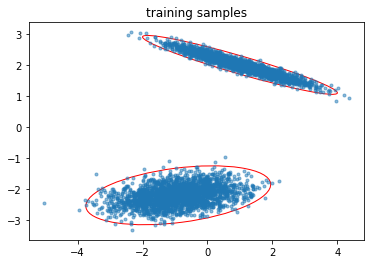

In [3]:
print_samples(train_x)

# ERM

[10000|10000] train_loss=3.57042e-02, valid_loss=8.02226e-01: 100%|██████████| 10000/10000 [11:01<00:00, 15.12it/s]


(200, 200)


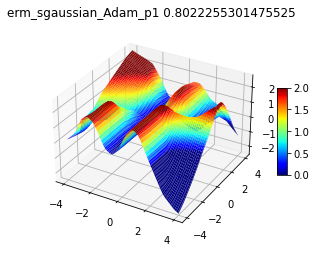

In [4]:

def train_ERM():
    pbar = tqdm(range(n_epoch))
    for ep in pbar:
        train_loss = 0
        for sub_x, sub_y in data_loader:
            sub_x=sub_x.to(device)
            sub_y=sub_y.to(device)
            loss = model.train_step(sub_x, sub_y)
            train_loss += len(sub_y) * loss
        train_loss /= len(train_y)

        y_pred, valid_loss = model.valid_loss(valid_x, valid_y)

        pbar.set_description(f'[{ep+1}|{n_epoch}] train_loss={train_loss:0.5e}, valid_loss={valid_loss:0.5e}')
    
    exp_name = f"{algorithm}_s{sampling}_{opt}_p{penalty_weight}"
    # print_predict(model,valid_loss,exp_name=exp_name)
    print_predict3D(model,valid_loss,exp_name=exp_name)
train_ERM()


In [5]:
def train_OOD():
    losses = []
    pbar = tqdm(range(n_epoch))
    for ep in pbar:
        train_loss = 0
        cur_losses = [0]*3
        if ep == anneal_epoch:
            if algorithm=='pair':
                if opt.lower() == 'adam':
                    model.optimizer = pt.optim.Adam(model.parameters(), lr=1e-3)
                elif opt.lower() == 'sgd':
                    model.optimizer = pt.optim.SGD(model.parameters(), lr=2e-3, momentum=0.9)
            else:
                model.optimizer = pt.optim.Adam(model.parameters(), lr=1e-3)
        for _, ((sub_x, sub_y), (sub_x2, sub_y2)) in enumerate(zip(data_loader1, data_loader2)):
            if ep < anneal_epoch:
                loss, sep_losses = model.train_step_ood(sub_x, sub_y, sub_x2, sub_y2)
            else:
                loss, sep_losses = model.train_step_ood(sub_x, sub_y, sub_x2, sub_y2, apply_ood_obj=True, penalty_weight=penalty_weight)
            train_loss += len(sub_y) * loss
            cur_losses = [l1+len(sub_y)*l2.item() for (l1,l2) in zip(cur_losses,sep_losses)]
        train_loss /= len(train_y)
        losses.append([l/len(train_y) for l in cur_losses])

        _, valid_loss = model.valid_loss(valid_x, valid_y)
        losses[-1][0] = valid_loss

        pbar.set_description(f'[{ep+1}|{n_epoch}] train_loss={train_loss:0.5e}, valid_loss={valid_loss:0.5e}')
    
    
    exp_name = f"{algorithm}_s{sampling}_{opt}_p{penalty_weight}"
    print_predict(model,valid_loss,exp_name=exp_name)
    # print_predict3D(model,valid_loss,exp_name=exp_name)
    plt.close()
    num_epochs = len(losses)
    fig, ax1 = plt.subplots()
    ax1.set_title(exp_name+f" {valid_loss}")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("val loss")
    # heuristic approach to beautify the visualization
    erm_vis_max = np.max([log_i[0] for log_i in losses[140:200]])+1e9
    erm_pens = np.array([min(log_i[0],erm_vis_max) for log_i in losses])
    ax1.plot(np.arange(num_epochs),erm_pens,label=f'erm_pen')
    ax2 = ax1.twinx()
    ax2.set_ylabel("penalty")
    if len(losses[0])>=3:
        irm_pens = np.array([min(log_i[-2],1) for log_i in losses])
        vrex_pens = np.array([min(log_i[-1],1) for log_i in losses])
        ax2.plot(np.arange(num_epochs),irm_pens,label=f'irm_pen',c='r',alpha=0.2)
        ax2.plot(np.arange(num_epochs),vrex_pens,label=f'vrex_pen',c='g',alpha=0.2)
    else:
        irm_pens = np.array([log_i[-1] for log_i in losses])
        ax2.plot(np.arange(num_epochs),irm_pens,label=f'irm_pen',c='r',alpha=0.2)
    plt.legend()
    plt.show()
    # plt.savefig(f"{exp_name}_s{sampling}.png")
    plt.close()

# if __name__ == '__main__':
#     print_truth()
#     if algorithm.lower() in ['vrex','irm','pair']:
#         train_VREx()
#     else:
#         train_ERM()

# IRM

[10000|10000] train_loss=4.81506e+00, valid_loss=1.01370e+00: 100%|██████████| 10000/10000 [16:49<00:00,  9.90it/s]


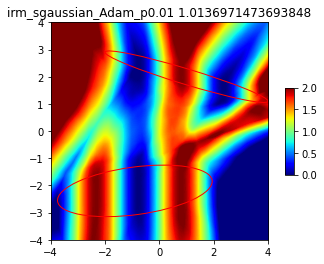

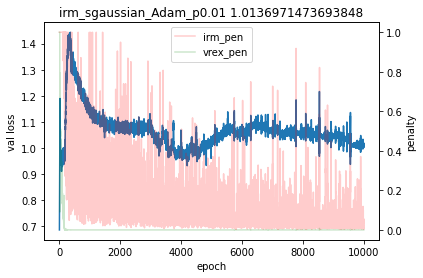

In [6]:
# IRM
algorithm = "irm"
penalty_weight = 1e-2
model = MLP().to(device)
train_OOD()

# VREX

[10000|10000] train_loss=2.12006e-01, valid_loss=6.44612e-01: 100%|██████████| 10000/10000 [15:56<00:00, 10.46it/s]


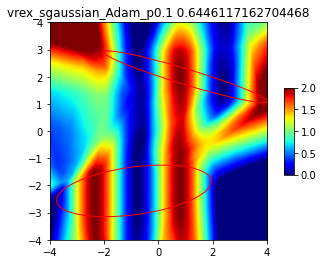

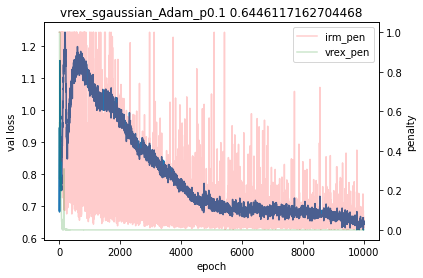

In [7]:
# vrex
algorithm = "vrex"
penalty_weight = 1e-1
model = MLP().to(device)
train_OOD()

# PAIR

[150|10000] train_loss=3.15613e+00, valid_loss=9.29974e-01:   1%|▏         | 149/10000 [00:14<17:05,  9.61it/s]

Restricted license - for non-production use only - expires 2023-10-25


[1204|10000] train_loss=2.06298e+00, valid_loss=7.60535e-01:  12%|█▏        | 1204/10000 [05:15<41:19,  3.55it/s]/home/yqchen/miniconda3/envs/gnn/lib/python3.8/site-packages/cvxpy/problems/problem.py:1339: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)
[10000|10000] train_loss=9.97147e-02, valid_loss=1.59599e+00: 100%|██████████| 10000/10000 [46:17<00:00,  3.60it/s]


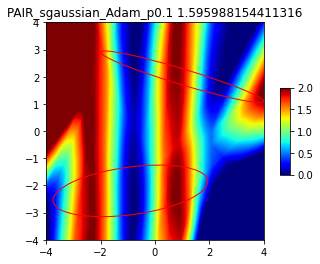

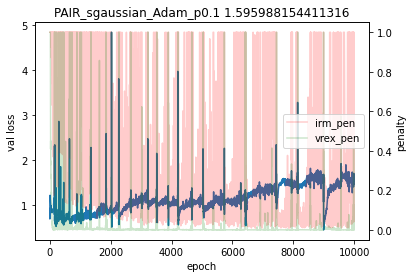

In [8]:
# PAIR
# define the preferences for the epo solver
algorithm = "PAIR"
r2, r = 1e4, 1e-8
preference = np.array([r]*1+[(1-r)/2,(1-r)/2])
model = MLP().to(device)
model.update_preference(preference)
train_OOD()

[10000|10000] train_loss=2.41655e-01, valid_loss=6.84301e-01: 100%|██████████| 10000/10000 [41:39<00:00,  4.00it/s]


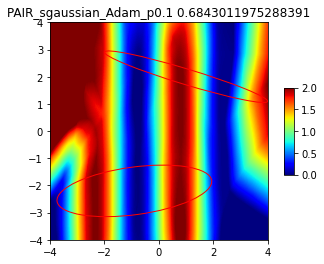

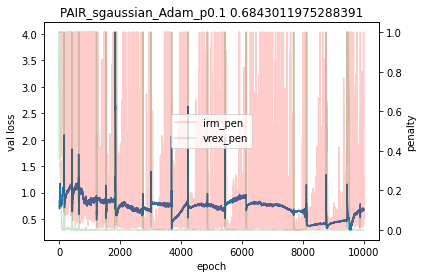

In [9]:
algorithm = "PAIR"
r2, r = 1e4, 1e-12
preference = np.array([r]*1+[(1-1*r-r2*r),r2*r])
model = MLP().to(device)
model.update_preference(preference)
train_OOD()